In [1]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 12.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [5]:
df = yf.download(tickers, period="max")
prices = df["Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2025-02-14,228.679993,46.959999,1071.849976,110.379997,476.660004,68.870003,308.549988,408.429993,2.64,112.550003
2025-02-18,226.649994,46.529999,1056.030029,109.559998,477.529999,69.050003,304.829987,409.640015,2.66,113.029999
2025-02-19,226.630005,46.009998,1062.540039,111.349998,475.350006,70.070000,301.940002,414.769989,2.65,112.489998
2025-02-20,222.880005,45.299999,1034.829956,110.550003,471.760010,70.040001,303.049988,416.130005,2.62,113.339996
2025-02-21,216.580002,44.810001,1035.030029,108.660004,462.369995,71.349998,304.809998,408.209991,2.63,111.750000


In [6]:
market_prices = yf.download("SPY", period="max")["Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
1993-01-29,24.526081
1993-02-01,24.700516
1993-02-02,24.752848
1993-02-03,25.014511
1993-02-04,25.119169


In [7]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3034624819200,
 'AMZN': 2295249764352,
 'NAT': 549133504,
 'BAC': 341042659328,
 'DPZ': 15966560256,
 'DIS': 196434460672,
 'KO': 306876350464,
 'MCD': 218432946176,
 'COST': 459448811520,
 'SBUX': 126940176384}

## Constructing the prior

In [8]:
import pypfopt
pypfopt.__version__

'1.5.6'

In [9]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.390720283957215

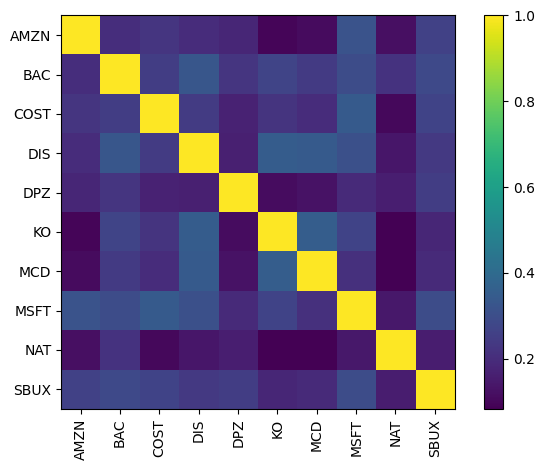

In [10]:
plotting.plot_covariance(S, plot_correlation=True);

In [11]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

,0
Ticker,
AMZN,0.212862
BAC,0.102619
COST,0.078156
DIS,0.090962
DPZ,0.038334
KO,0.052505
MCD,0.057670
MSFT,0.152962
NAT,0.041047


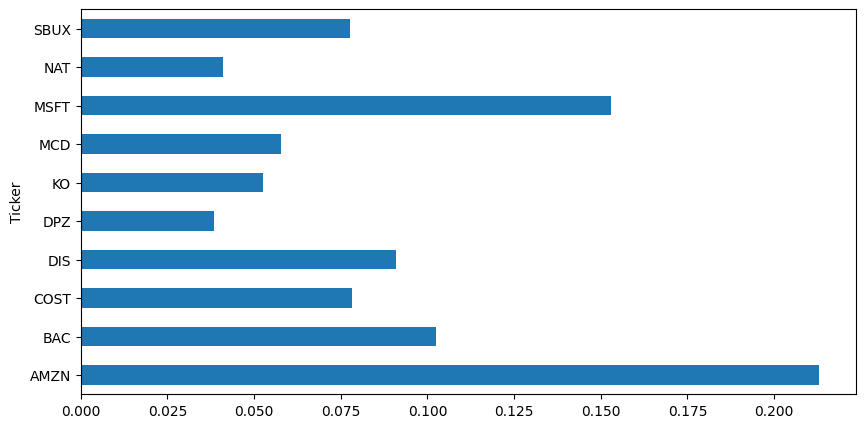

In [12]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [13]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [14]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]

In [15]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

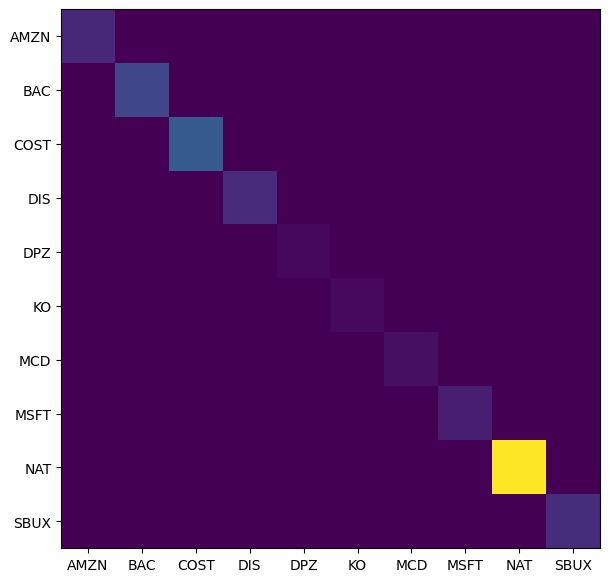

In [16]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [17]:
np.diag(bl.omega)

array([0.0045608 , 0.00875645, 0.01200582, 0.00493122, 0.00087679,
       0.0011265 , 0.00168058, 0.00344459, 0.04136062, 0.00547894])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [18]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [19]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [20]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [21]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

,0
Ticker,
AMZN,0.182584
BAC,0.136097
COST,0.069399
DIS,0.074128
DPZ,0.107327
KO,0.008594
MCD,0.103716
MSFT,0.106683
NAT,0.063667


We can visualise how this compares to the prior and our views:

In [22]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.212862,0.182584,0.10
BAC,0.102619,0.136097,0.30
COST,0.078156,0.069399,0.05
DIS,0.090962,0.074128,0.05
DPZ,0.038334,0.107327,0.20
KO,0.052505,0.008594,-0.05
MCD,0.057670,0.103716,0.15
MSFT,0.152962,0.106683,0.10
NAT,0.041047,0.063667,0.50
SBUX,0.077822,0.087228,0.10


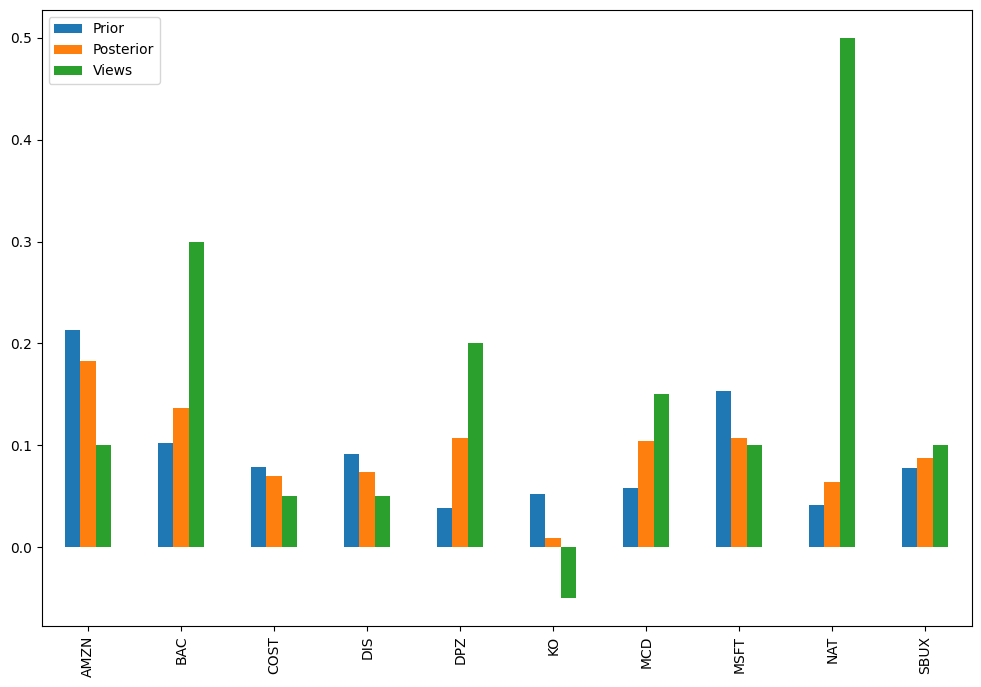

In [23]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

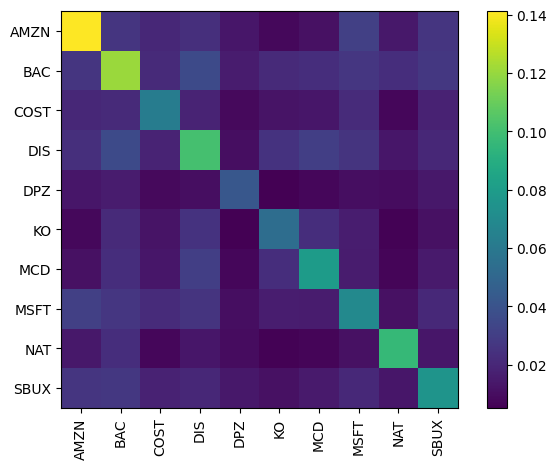

In [24]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [25]:
from pypfopt import EfficientFrontier, objective_functions

In [26]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.19867),
             ('BAC', 0.14325),
             ('COST', 0.07223),
             ('DIS', 0.07013),
             ('DPZ', 0.12752),
             ('KO', 0.0),
             ('MCD', 0.11586),
             ('MSFT', 0.11516),
             ('NAT', 0.06637),
             ('SBUX', 0.09083)])

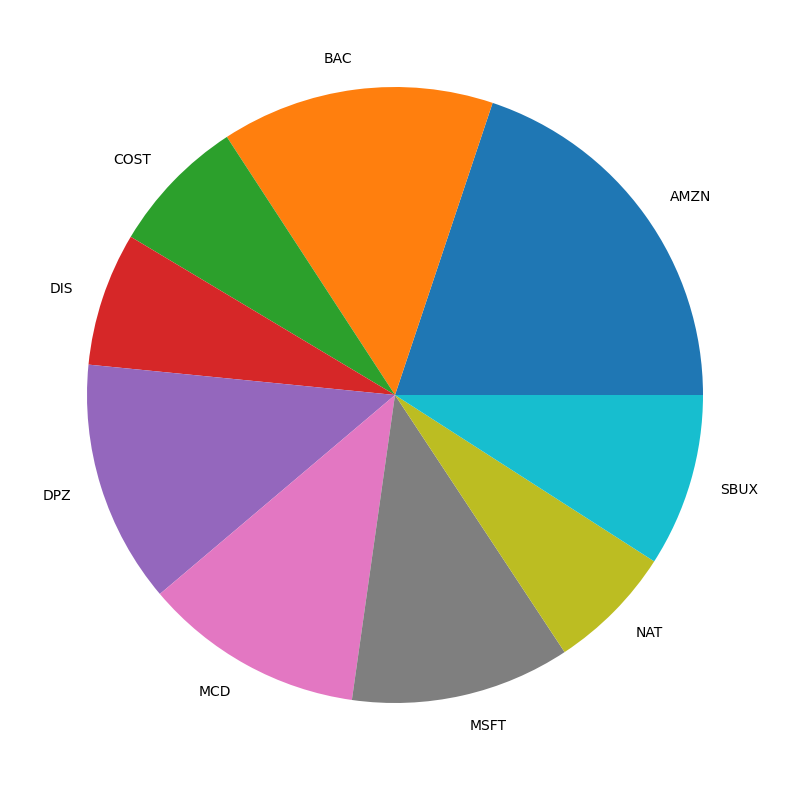

In [27]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [28]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $8.00


{'AMZN': 18,
 'BAC': 64,
 'COST': 1,
 'DIS': 13,
 'DPZ': 6,
 'MCD': 8,
 'MSFT': 6,
 'NAT': 505,
 'SBUX': 16}